# Notebook COVID Related Reduction in Mobility
## Last Updated: 10-08-2020

In [148]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import json
import warnings
import datetime
import sys
sys.path.append('.')
from src.utils import collect_data
from src.utils import eda
from sklearn.model_selection import train_test_split
import catboost
from sklearn.metrics import r2_score
from catboost import Pool
import shap
from sklearn.preprocessing import MinMaxScaler

In [149]:
import importlib
importlib.reload(collect_data)

<module 'src.utils.collect_data' from 'C:\\Work\\projects\\mobility\\US_Mobility_BTS\\src\\utils\\collect_data.py'>

In [150]:
collect_datasets = collect_data.DataCollection()
data_analysis = eda.DataAnalysis()

In [242]:
# df_mobility = collect_datasets.get_mobility_data()
# df_mobility_rm = collect_datasets.get_mobility_data(rolling_mean=True)
# df_county_spending = collect_datasets.get_spend_data()
# df_covid = collect_datasets.combine_covid_data()
# df_county = collect_datasets.combined_county_data()
# df_ur = collect_datasets.load_unemployment()

mob_cols =  ['mobility_per_trip', 'mobility_per_person', 'trips_per_person', 'Number of Trips',
                        'pct_not_home'] + [col for col in df_mobility.columns if 'Number of Trips ' in col][:6]
df_mob_red = collect_datasets.get_mob_red(df_mobility_rm,col_list=mob_cols)
df_mob_red = df_mob_red[~df_mob_red['loc'].str.contains(' AK')]

In [244]:
df_pop_est = pd.read_excel('./data/datasets/Demographics/PopulationEstimates.xls',
                           sheet_name='Population Estimates 2010-19',header=2)
df_pop_est = df_pop_est.drop(columns = ['State','Area_Name'])
df_pop_est = df_pop_est.rename(columns = {'FIPStxt':'fips'})
df_pop_est['fips'] = df_pop_est.fips.astype(str).str.zfill(5)
df_pop_est = df_pop_est.dropna()
df_pop_est

fips  Rural-urban_Continuum Code_2003  Rural-urban_Continuum Code_2013  \
2     01001                              2.0                              2.0   
3     01003                              4.0                              3.0   
4     01005                              6.0                              6.0   
5     01007                              1.0                              1.0   
6     01009                              1.0                              1.0   
...     ...                              ...                              ...   
3189  56037                              5.0                              5.0   
3190  56039                              7.0                              7.0   
3191  56041                              7.0                              7.0   
3192  56043                              7.0                              7.0   
3193  56045                              7.0                              7.0   

      Urban_Influence_Code_2003  Urban_Influence_Code_2013  \
2                           2.0                        2.0   
3                           5.0                        2.0   
4                           6.0                        6.0   
5                           1.0                        1.0   
6                           1.0                        1.0   
...                         ...                        ...   
3189                        8.0                        8.0   
3190                        8.0                        8.0   
3191                        8.0                        8.0   
3192                       11.0                       11.0   
3193                        9.0                        9.0   

      Economic_typology_2015  CENSUS_2010_POP  ESTIMATES_BASE_2010  \
2                        0.0            54571                54597   
3                        5.0           182265               182265   
4                        3.0            27457                27455   
5                        0.0            22915                22915   
6                        0.0            57322                57322   
...                      ...              ...                  ...   
3189                     2.0            43806                43806   
3190                     5.0            21294                21298   
3191                     2.0            21118                21121   
3192                     0.0             8533                 8528   
3193                     2.0             7208                 7208   

      POP_ESTIMATE_2010  POP_ESTIMATE_2011  ...  R_DOMESTIC_MIG_2019  \
2                 54773              55227  ...             4.847310   
3                183112             186558  ...            24.017829   
4                 27327              27341  ...            -5.690302   
5                 22870              22745  ...             1.385134   
6                 57376              57560  ...             1.020788   
...                 ...                ...  ...                  ...   
3189              43574              43986  ...           -17.605427   
3190              21296              21414  ...            -1.583464   
3191              21089              20896  ...            -9.181105   
3192               8530               8449  ...            -7.652085   
3193               7198               7142  ...             0.000000   

      R_NET_MIG_2011  R_NET_MIG_2012  R_NET_MIG_2013  R_NET_MIG_2014  \
2           6.018182       -6.226119       -3.902226        1.970443   
3          16.641870       17.488579       22.751474       20.184334   
4           0.292676       -6.897817       -8.132185       -5.140431   
5          -4.998356       -3.787545       -5.797999        1.331144   
6           0.208812       -1.650165       -0.347225       -2.049590   
...              ...             ...             ...             ...   
3189        0.502513       15.035735       -4.614071      -13.140225   
3190   

In [245]:
df_hi = pd.read_csv('./Data/datasets/Demographics/health_ineq_online_table_12.csv',encoding='latin')
df_hi['fips'] = df_hi.cty.astype(str).str.zfill(5)
df_hi = df_hi.drop(columns = ['county_name','cty_pop2000','cz','cz_name',
                              'state_id','stateabbrv','cz_pop2000','statename','csa',
                             'csa_name','cbsa','cbsa_name','intersects_msa','cty'])
df_hi

cur_smoke_q1  cur_smoke_q2  cur_smoke_q3  cur_smoke_q4  bmi_obese_q1  \
0         0.333333      0.238095      0.208333      0.133333      0.375000   
1         0.268097      0.233503      0.167464      0.176991      0.298050   
2         0.228571      0.250000      0.181818      0.111111      0.294118   
3         0.244444      0.280000      0.181818      0.150000      0.466667   
4         0.304348      0.260870      0.352941      0.166667      0.347826   
...            ...           ...           ...           ...           ...   
3133      0.349305      0.302658      0.227799      0.178484      0.247209   
3134      0.263415      0.182017      0.092105      0.053913      0.127451   
3135      0.345538      0.237718      0.197943      0.130682      0.283019   
3136      0.260163      0.195652      0.083333      0.076923      0.283186   
3137      0.318841      0.241935      0.264706      0.266667      0.181818   

      bmi_obese_q2  bmi_obese_q3  bmi_obese_q4  exercise_any_q1  \
0         0.238095      0.260870      0.133333         0.500000   
1         0.262467      0.193237      0.135747         0.599432   
2         0.571429      0.545455      0.277778         0.542857   
3         0.375000      0.190476      0.100000         0.422222   
4         0.318182      0.529412      0.235294         0.565217   
...            ...           ...           ...              ...   
3133      0.226943      0.254593      0.257500         0.622924   
3134      0.099338      0.113333      0.072056         0.816327   
3135      0.247154      0.224274      0.235294         0.611247   
3136      0.139706      0.265306      0.194444         0.617886   
3137      0.290323      0.218750      0.285714         0.550725   

      exercise_any_q2  ...  cs_educ_ba  tuition  gradrate_r  e_rank_b  \
0            0.666667  ...        18.0      NaN         NaN  41.87288   
1            0.748677  ...        23.1  2055.67   -0.247166  44.49239   
2            0.571429  ...        10.9      NaN         NaN  37.71876   
3            0.560000  ...         7.1      NaN         NaN  42.24516   
4            0.478261  ...         9.6      NaN         NaN  49.04332   
...               ...  ...         ...      ...         ...       ...   
3133         0.765677  ...        17.0  1128.00    0.158455  56.36696   
3134         0.891455  ...        45.8      NaN         NaN  52.44689   
3135         0.793624  ...        15.0      NaN         NaN  55.72552   
3136         0.775362  ...        18.7      NaN         NaN  50.83900   
3137         0.730159  ...        14.5      NaN         NaN  59.99648   

      cs_fam_wkidsinglemom  crime_total  subcty_exp_pc   taxrate  \
0                 0.191595     0.009353      1059.6690  0.011183   
1                 0.186779     0.007371      2209.9100  0.011756   
2                 0.337853     0.007749      1570.2480  0.012059   
3                 0.197729     0.004514      1338.4410  0.008007   
4                 0.121988     0.002019       987.4388  0.007012   
...                    ...          ...            ...       ...   
3133              0.169972     0.011671      4166.1130  0.051011   
3134              0.153690     0.003835      5373.5230  0.043496   
3135              0.169347     0.004660      3627.8000  0.056147   
3136              0.143126     0.013632      2368.8600  0.020641   
3137              0.148103     0.004214      3820.9580  0.025310   

      tax_st_diff_top20   fips  
0                   0.0  01001  
1                   0.0  01003  
2                   0.0  01005  
3                   0.0  01007  
4                   0.0  01009  
...                 ...    ...  
3133                0.0  56037  
3134                0.0  56039  
3135                0.0  56041  
3136                0.0  56043  
3137                0.0  56045  

[3138 rows x 63 columns]

In [246]:
df_quart_emp_wages = pd.read_excel('./data/datasets/Demographics/allhlcn201.xlsx',sheet_name='US_St_Cn_MSA')
df_quart_emp_wages = df_quart_emp_wages[df_quart_emp_wages['Area Type']=='County'].reset_index(drop=True)
df_quart_emp_wages = df_quart_emp_wages.rename(columns={'Area\nCode':'fips'})
df_quart_emp_wages = df_quart_emp_wages.drop(columns=['St','Cnty','Own','Year','Qtr',
                                                      'Area Type','St Name','Area','Industry','Status Code'])
cols = [col for col in df_quart_emp_wages.columns if col not in ['fips','Ownership','NAICS']]
df_quart_emp_wages = df_quart_emp_wages.groupby(['fips','Ownership','NAICS'])[cols].mean().unstack(level=[1,2]).reset_index()
df_quart_emp_wages

fips Establishment Count                                          \
Ownership         Federal Government Local Government Private                  
NAICS                             10               10      10    101     102   
0          01001                10.0             32.0   849.0  138.0   711.0   
1          01003                34.0             91.0  6491.0  977.0  5514.0   
2          01005                 9.0             31.0   510.0   87.0   423.0   
3          01007                10.0             31.0   317.0   75.0   242.0   
4          01009                10.0             44.0   726.0  171.0   555.0   
...          ...                 ...              ...     ...    ...     ...   
3187       56039                14.0             12.0  2461.0  436.0  2025.0   
3188       56041                13.0             18.0   721.0  145.0   576.0   
3189       56043                 8.0             16.0   402.0   96.0   306.0   
3190       56045                 8.0             21.0   250.0   77.0   173.0   
3191       56999                30.0              NaN   588.0  153.0   435.0   

                                       ...  \
Ownership                              ...   
NAICS      1011   1012   1013    1021  ...   
0          25.0   90.0   23.0   201.0  ...   
1          77.0  687.0  213.0  1526.0  ...   
2          27.0   31.0   29.0   138.0  ...   
3          14.0   38.0   23.0    89.0  ...   
4          13.0  108.0   50.0   189.0  ...   
...         ...    ...    ...     ...  ...   
3187       26.0  374.0   36.0   341.0  ...   
3188       43.0   81.0   21.0   164.0  ...   
3189       40.0   43.0   13.0    87.0  ...   
3190       40.0   33.0    4.0    61.0  ...   
3191       29.0  121.0    3.0   128.0  ...   

          Total Wage Location Quotient Relative to U.S.                    \
Ownership                                       Private                     
NAICS                                              1021  1022  1023  1024   
0                                                  1.35  0.08  0.37  0.34   
1                                                  1.47  0.18  0.63  0.46   
2                                                  1.11  0.05  0.28  0.20   
3                                                  1.06  0.00  0.14  0.14   
4                                                  1.29  0.31  0.35  0.33   
...                                                 ...   ...   ...   ...   
3187                                               0.71  0.26  0.90  0.77   
3188                                               1.42  1.20  0.41  0.32   
3189                                               1.42  0.45  0.35  0.17   
3190                                               0.89  0.18  0.29  0.13   
3191                                               1.00  0.00  0.29  1.14   

                                                                    
Ownership                   State Government Total Covered Private  
NAICS      1025  1026  1027               10            10    1029  
0          0.72  1.08  0.84             1.82           1.0     NaN  
1          1.25  2.54  1.31             0.50           1.0     NaN  
2          0.70  0.78  0.73             2.49           1.0     NaN  
3          0.75  0.27  0.00             1.87           1.0     NaN  
4          0.91  0.84  1.52             0.67           1.0     NaN  
...         ...   ...   ...              ...           ...     ...  
3187       0.45  6.53  1.28             0.21           1.0    0.75  
3188       0.95  0.79  0.52             2.28           1.0    0.66  
3189       1.19  0.55  0.83             1.60           1.0     NaN  
3190       0.44  0.52  0.50             2.38           1.0     NaN  
3191       0.15  0.01  0.00             0.00           1.0    1.29  

[3192 rows x 145 columns]

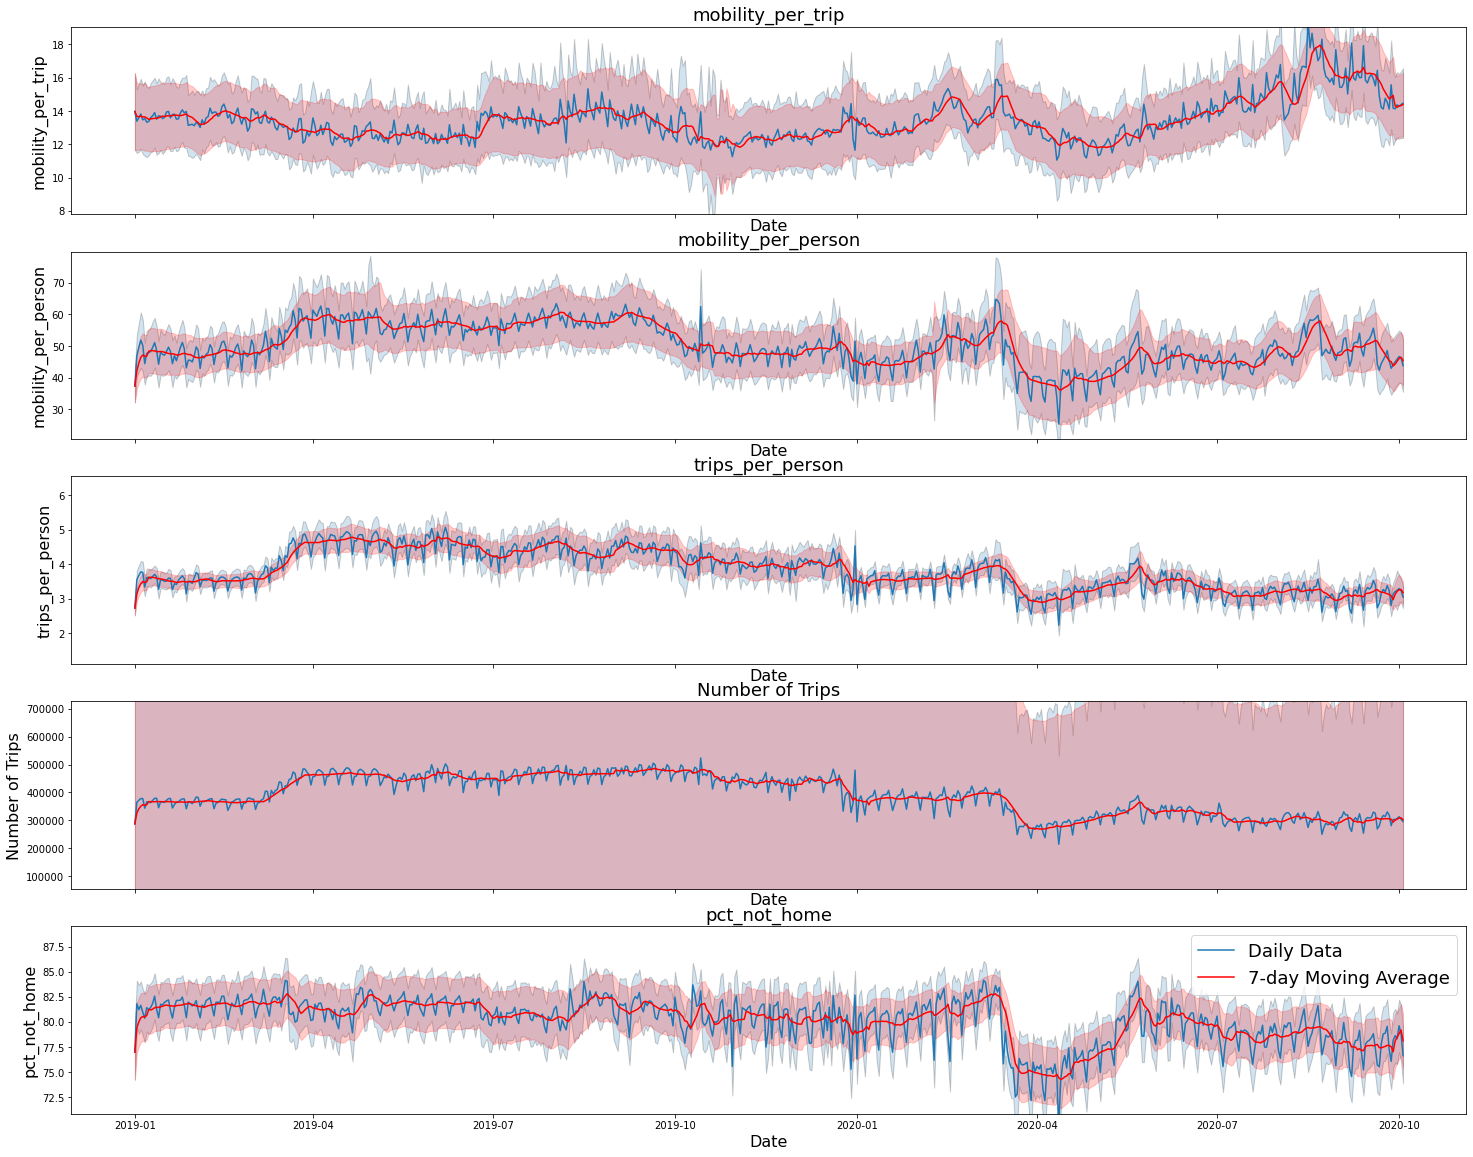

In [183]:
trip_cols = [col for col in df_mobility_rm.columns if 'Number of Trips ' in col]
mob_cols = [col for col in df_mobility_rm.columns if col not in ['fips','date'] and col not in trip_cols]
data_analysis.plot_metric(df_mobility,var_list=mob_cols,rolling_mean=True,df_mob_rm=df_mobility_rm)

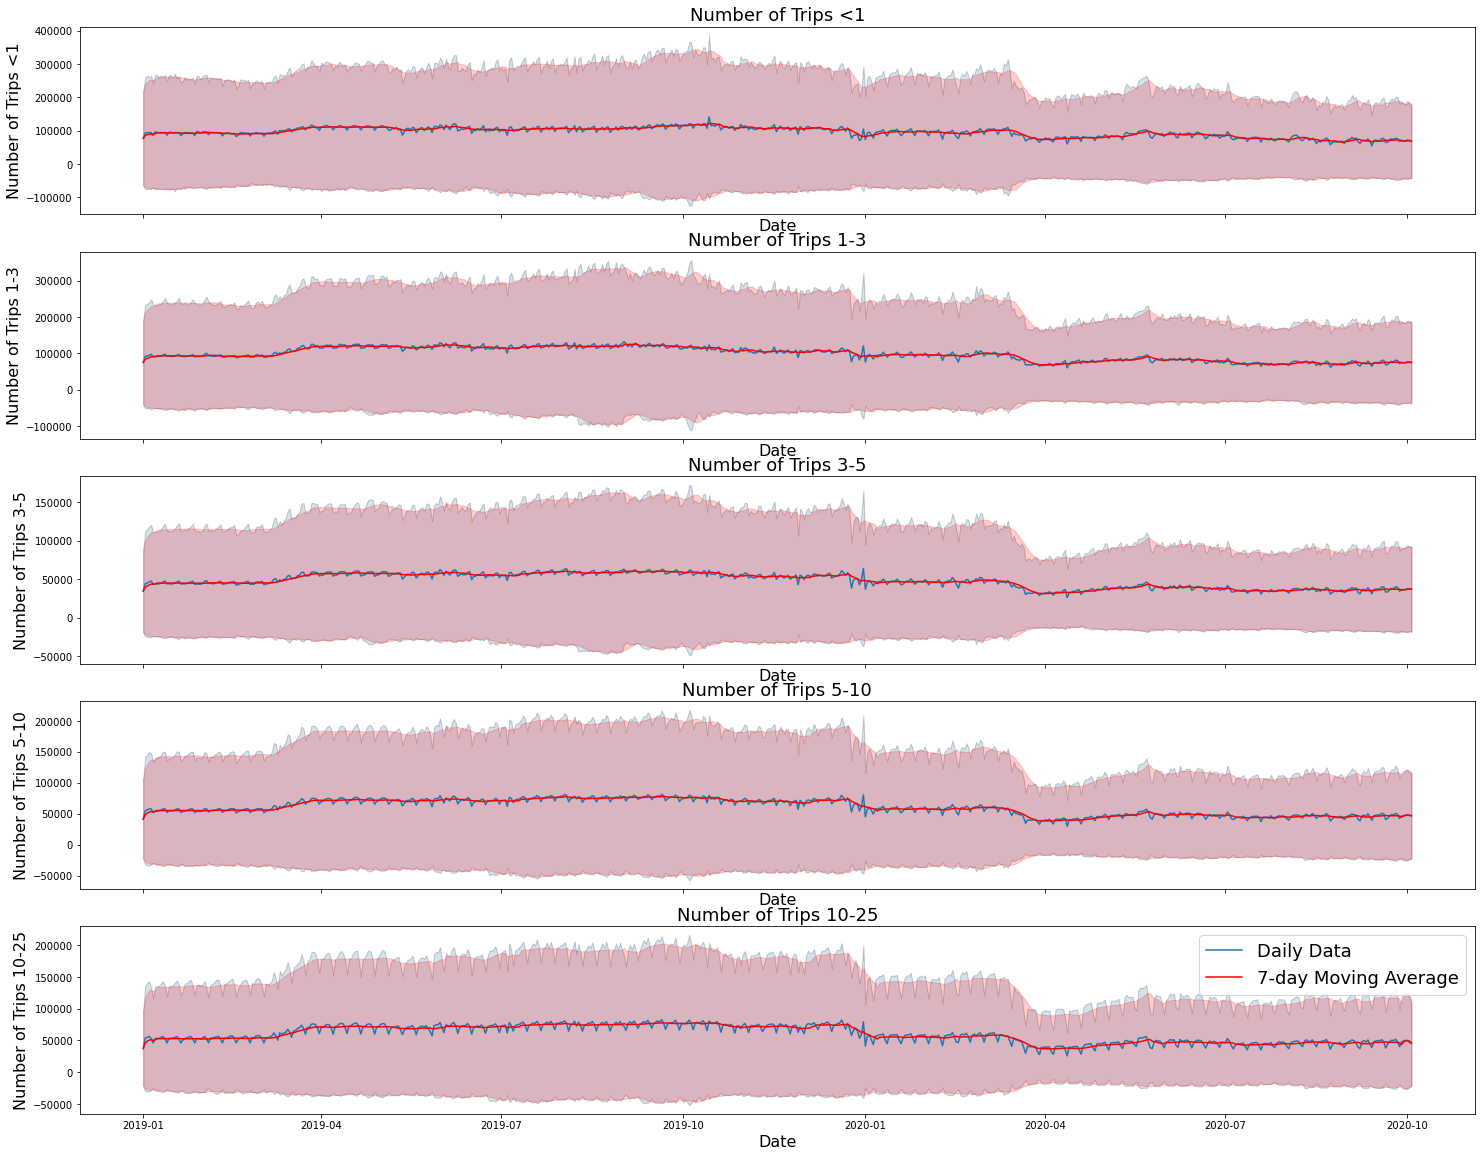

In [121]:
data_analysis.plot_metric(df_mobility,var_list=trip_cols[:5],rolling_mean=True,df_mob_rm=df_mobility_rm,auto_y_lim=True)

In [430]:
mob_cols =  ['mobility_per_trip', 'mobility_per_person', 'trips_per_person', 'Number of Trips',
                        'pct_not_home']# + [col for col in df_mobility.columns if 'Number of Trips ' in col][:6]
df_mob_red = collect_datasets.get_mob_red(df_mobility_rm,col_list=mob_cols)
df_mob_red = df_mob_red[~df_mob_red['loc'].str.contains(' AK')]
sc = MinMaxScaler()
cols = ['mobility_per_trip','mobility_per_person','Number of Trips','pct_not_home']
target_cols_red = [col for col in df_mob_red.columns if col in red_cols+norm_cols+days_cols and 'min' not in col.lower()]
for col in target_cols_red:
    df_mob_red = df_mob_red[df_mob_red[col]>0]
red_cols = ['Pct_Red_' +s for s in cols]
norm_cols = ['Norm_Drop_Rate_' +s for s in cols]
days_cols = ['Drop_days_' +s for s in cols]

# target_cols_red = [col for col in df_mob_red.columns if col in red_cols+norm_cols+days_cols and 'min' not in col.lower()]
target_cols_red = [col for col in df_mob_red.columns if '_Number of Trips' in col and 'min' not in col.lower()]

# for col in target_cols_red:
#     df_mob_red['Scaled_'+col] = sc.fit_transform(df_mob_red[col].values.reshape(-1,1))
df_mob_red = df_mob_red.reset_index(drop=True)
df_mob_red

fips  mobility_per_trip  mobility_per_person  trips_per_person  \
0     01001          11.666363            41.482726          3.559118   
1     01003          11.468172            38.225773          3.335479   
2     01005          13.291331            49.978746          3.768950   
3     01007          12.735197            50.748360          3.996779   
4     01009          15.133751            55.969922          3.696247   
...     ...                ...                  ...               ...   
3089  56037          13.399980            50.170899          3.781704   
3090  56039          11.964547            48.029008          4.033003   
3091  56041          17.024152            62.270303          3.675259   
3092  56043          17.424443            51.943510          3.117114   
3093  56045          37.604261           137.297547          3.636086   

      Number of Trips  pct_not_home  Min_mobility_per_trip  \
0       197890.492857     85.786895               8.399703   
1       727207.842857     83.624732               9.611103   
2        93775.235714     86.019424               9.668717   
3        89527.850000     87.576786               9.537722   
4       213790.928571     87.255693              10.969546   
...               ...           ...                    ...   
3089    162806.121429     76.763407              11.758502   
3090     93085.735714     82.247086               9.375911   
3091     74604.085714     78.785971              15.462451   
3092     24578.442857     66.095208               8.051559   
3093     25332.614286     81.129919              26.584348   

      Min_mobility_per_person  Min_trips_per_person  Min_Number of Trips  ...  \
0                   26.369223              2.665695        148215.285714  ...   
1                   22.477071              2.319520        505706.428571  ...   
2                   31.040880              2.802646         69732.642857  ...   
3                   33.147376              2.639656         59128.285714  ...   
4                   34.850934              2.766840        160034.000000  ...   
...                       ...                   ...                  ...  ...   
3089                35.506059              2.527232        108799.857143  ...   
3090                26.035057              2.481026         57264.571429  ...   
3091                45.675371              2.447981         49691.571429  ...   
3092                23.906368              2.027738         15988.714286  ...   
3093                61.971437              2.159266         15043.607143  ...   

      Drop_days_trips_per_person Norm_Drop_Rate_trips_per_person  \
0                             21                        0.011954   
1                             34                        0.008959   
2                            197                        0.001301   
3                            168                        0.002021   
4                             18                        0.013969   
...                          ...                             ...   
3089                         182                        0.001823   
3090                          31                        0.012414   
3091                         197                        0.001695   
3092                          32                        0.010921   
3093                         197                        0.002062   

     Pct_Red_trips_per_person Drop_days_Number of Trips  \
0                    0.251024                        21   
1                    0.304592                        34   
2                    0.256385                       197   
3                    0.339554                       168   
4                    0.251446                        18   
...                       ...                       ...   
3089                 0.331721                       182   
3090                 0.384819                        31   
3091                 0.333930                       197   
3092 

In [431]:
def plot_metric(df, col_list,x_label):
    
    plt.figure(figsize=(12,12))
    plt.rcParams["patch.force_edgecolor"] = True
      
    plt.hist(df[col_list].values,density=True,bins=20,stacked=False,alpha=0.7)

    plt.xlabel(x_label,fontsize=18)
    labels = [s.replace('Pct_Red_','') for s in col_list]
    
    plt.ylabel('Count', fontsize = 18)
    plt.legend(labels,fontsize=20,bbox_to_anchor=(1.05, 1))

In [432]:
for col in target_cols_red:
    if 'days' in col:
        df_mob_red[col] = (df_mob_red[col].max()- df_mob_red[col])+1

In [378]:
drop_col = [col for col in target_cols_red if 'days' in col]
df_mob_red[drop_col[0]] = (df_mob_red[drop_col[0]].max()- df_mob_red[drop_col[0]])+1

In [433]:
df_mob_red['Mob_Red_Index'] = df_mob_red.loc[:, target_cols_red].prod(axis=1)

In [434]:
target_cols_red

['Drop_days_Number of Trips',
 'Norm_Drop_Rate_Number of Trips',
 'Pct_Red_Number of Trips']

In [435]:
df_mob_red[df_mob_red['Mob_Red_Index'] ==0][target_cols_red+['loc']]

Empty DataFrame
Columns: [Drop_days_Number of Trips, Norm_Drop_Rate_Number of Trips, Pct_Red_Number of Trips, loc]
Index: []

In [436]:
df_mob_red['log_Mob_Red_Index'] = np.log10(df_mob_red['Mob_Red_Index'].replace(0,1e-3))

<AxesSubplot:>

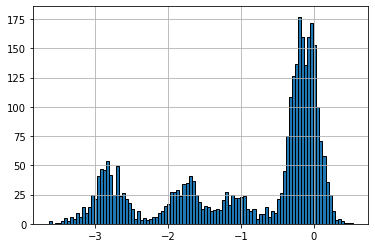

In [437]:
df_mob_red['log_Mob_Red_Index'].hist(bins=100)

<AxesSubplot:>

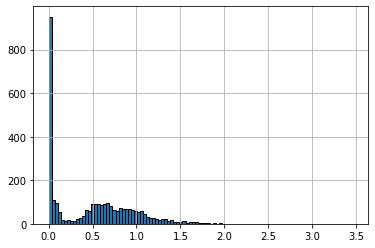

In [438]:
df_mob_red['Mob_Red_Index'].hist(bins=100)

<AxesSubplot:>

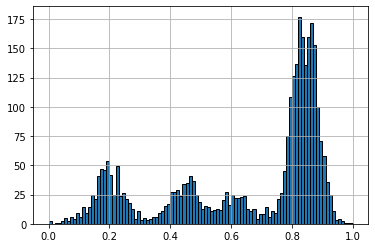

In [439]:
df_mob_red['Mob_Red_Index_scaled']  = sc.fit_transform(df_mob_red['log_Mob_Red_Index'].values.reshape(-1,1))
df_mob_red['Mob_Red_Index_scaled'].hist(bins=100)

In [440]:
cols = ['log_Mob_Red_Index']

data_analysis.plot_map(col_list=cols,df=df_mob_red,save_op=False)

In [253]:
df_mob_red[df_mob_red['Mob_Red_Index']>0.3]

fips  mobility_per_trip  mobility_per_person  trips_per_person  \
256   08091          17.212227            71.162118          4.029336   
531   16035          13.569738            38.835231          2.855816   
532   16037          28.595579            86.342669          3.028385   
543   16059          15.634053            43.534017          2.818741   
564   17013          20.182578            79.819914          4.033895   
867   20033          18.443406            97.221678          5.279287   
882   20065          21.255577            78.077120          3.685293   
891   20083          21.581512            93.663967          4.473947   
992   21075          13.312495            68.000235          5.100496   
1188  25019           5.510504            31.006847          5.668269   
1290  27029          22.272751            79.571870          3.599546   
1562  30005          28.697419            72.339967          2.561731   
1567  30015          19.390836            57.313452          2.995390   
1608  30097          13.264543            43.699327          3.281386   
1651  31073          19.570592            90.936908          4.728682   
1653  31077          23.951668            96.203934          4.001980   
1705  31181          12.028577            49.778870          4.164354   
1952  38009          15.440675            48.575736          3.168706   
1961  38027          19.976414            66.422426          3.263674   
1970  38045          24.419299            57.535982          2.401277   
1982  38069          15.567615            50.717812          3.472104   
2212  42023          12.995672            35.398132          2.792800   
2318  46003          18.679966            72.103106          3.912840   
2329  46025          16.740387            74.816335          4.516183   
2351  46069          15.489238            90.746395          5.807577   
2362  46091          15.359810            63.731116          4.236588   
2371  46107          21.892369            67.302787          3.149608   
2581  48205          20.734663            68.977387          3.355853   
2584  48211          14.291957            47.417796          3.407559   
2888  51678          12.189526            38.000766          3.191422   
2918  53019          14.817394            42.920884          2.942860   
2994  54093          12.510132            42.355388          3.374878   
3021  55037          16.506597            64.984699          4.022234   

      Number of Trips  pct_not_home  Number of Trips <1  Number of Trips 1-3  \
256      19473.778571     84.025302         3062.314286          3114.928571   
531      25011.235714     77.249372         4765.792857          6078.221429   
532      12961.485714     82.128838         2585.042857          1587.664286   
543      22440.000000     79.828898         4865.071429          5838.771429   
564      19370.764286     86.263313         2606.507143          3991.071429   
867       9228.192857     68.655606         4037.814286          1541.621429   
882       9183.750000     76.555836         2073.078571          3083.150000   
891       8133.635714     70.005893         2949.707143           777.714286   
992      31215.035714     82.388305        10257.350000          7735.221429   
1188     64204.478571     77.394027        20383.085714         26938.721429   
1290     31712.000000     87.009648         5223.035714          5636.950000   
1562     17437.700000     76.284707         2984.685714          1433.407143   
1567     17208.514286     71.894567         5474.257143          2983.400000   
1608     12173.942857     83.294186         2308.642857          5632.985714   
1651      9438.450000     91.828657         1520.992857          2449.285714   
1653      9428.664286     83.610235         1949.928571           589.900000   
1705     14712.664286     79.074239         3279.964286          4278.892857   
1952     20314.571429     75.448337         6338.021429          4124.642857   
1961

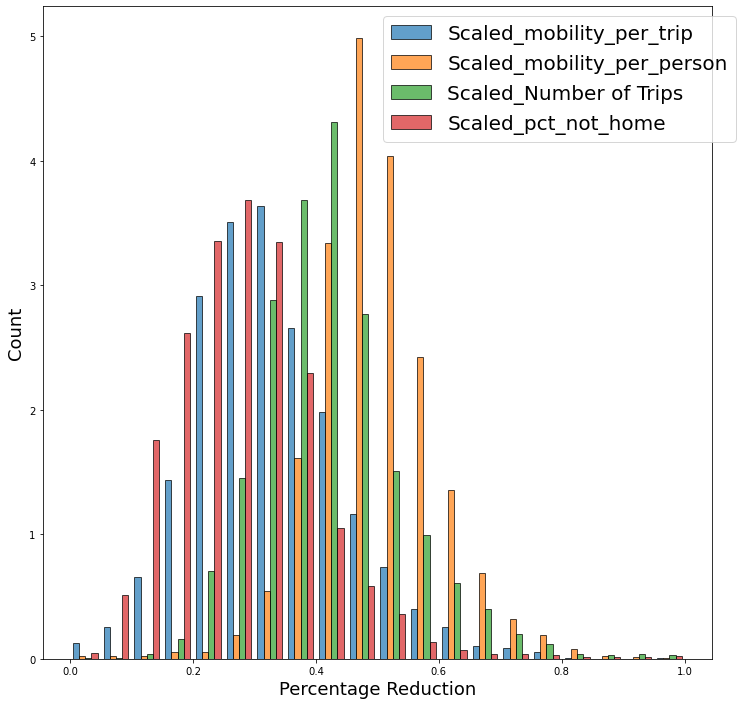

In [165]:
scaled_cols = [col for col in df_mob_red.columns if 'Scaled' in col]
plot_metric(df_mob_red,scaled_cols,x_label='Percentage Reduction')

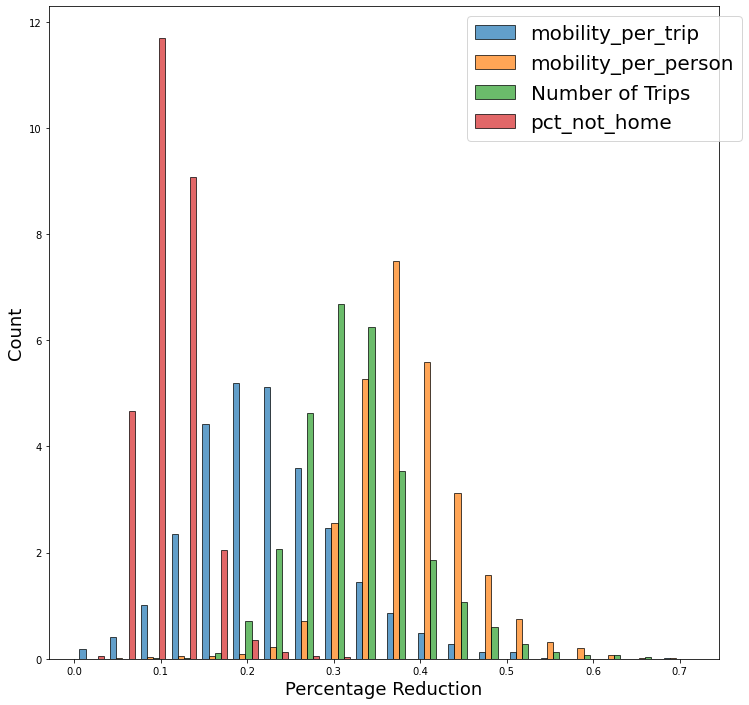

In [166]:
cols = ['mobility_per_trip','mobility_per_person','Number of Trips','pct_not_home']
target_cols_red = ['Pct_Red_' + col for col in cols]
plot_metric(df_mob_red,target_cols_red,x_label='Percentage Reduction')

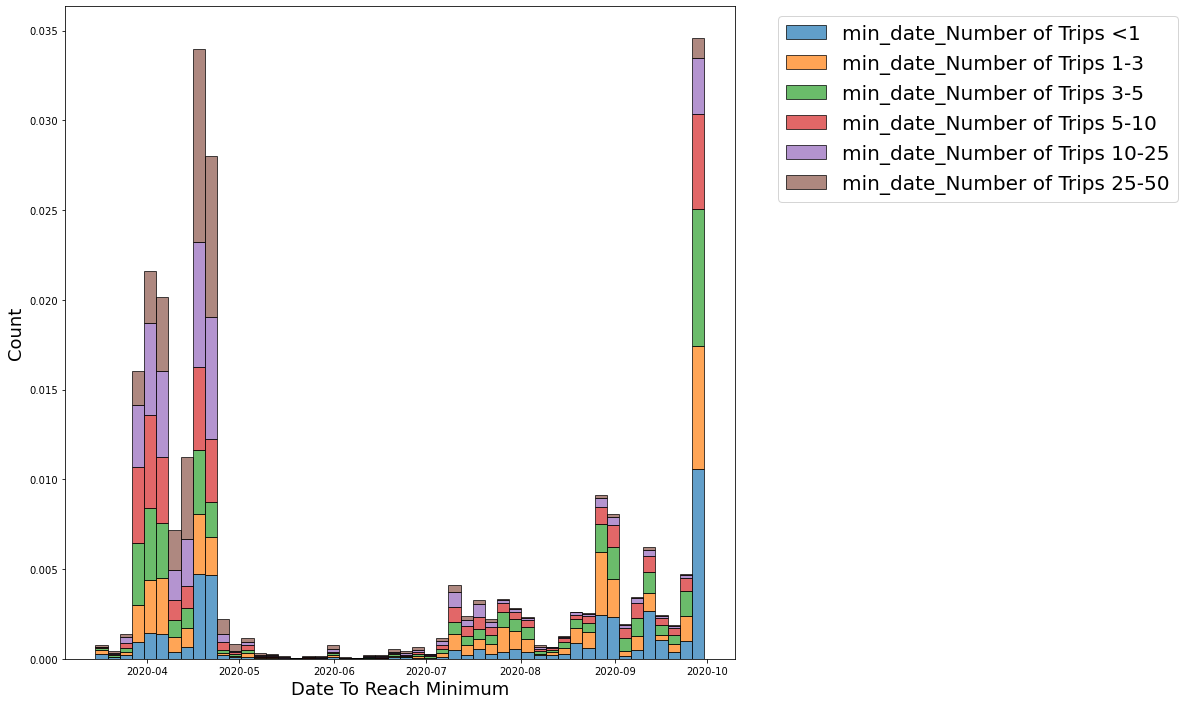

In [97]:
target_cols_red = [col for col in df_mob_red.columns if 'min_date_Number of Trips ' in col]
plot_metric(df_mob_red,target_cols_red,x_label='Date To Reach Minimum')

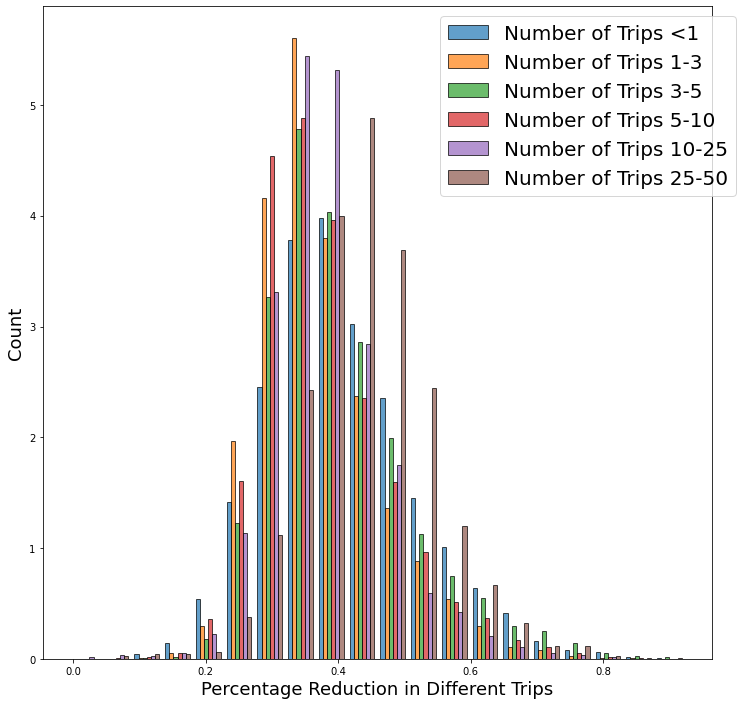

In [213]:
target_cols_red = [col for col in df_mob_red.columns if 'Pct_Red_Number of Trips ' in col]
plot_metric(df_mob_red,target_cols_red,x_label='Percentage Reduction in Different Trips')

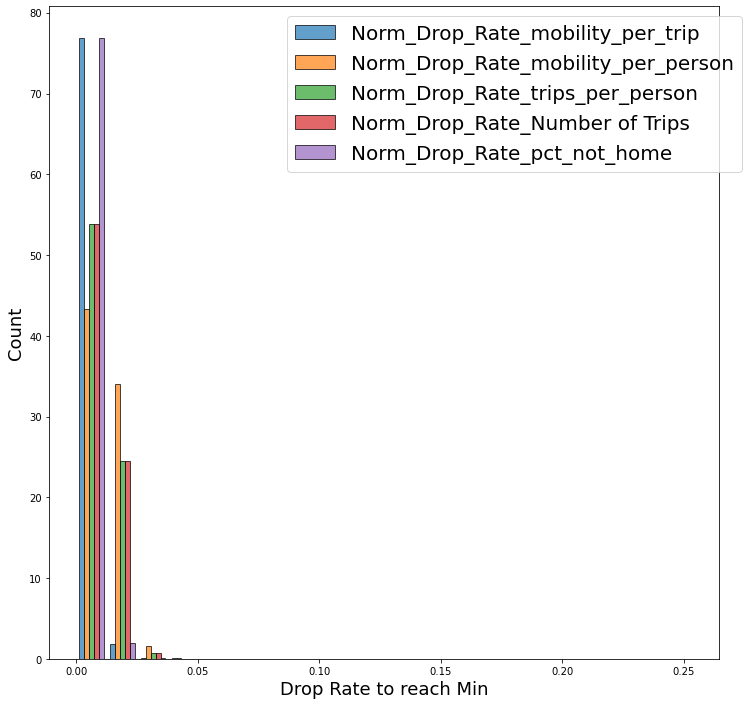

In [212]:
target_cols_red = [col for col in df_mob_red.columns if 'Norm_' in col and 'Number of Trips ' not in col]
plot_metric(df_mob_red,target_cols_red,x_label='Drop Rate to reach Min')

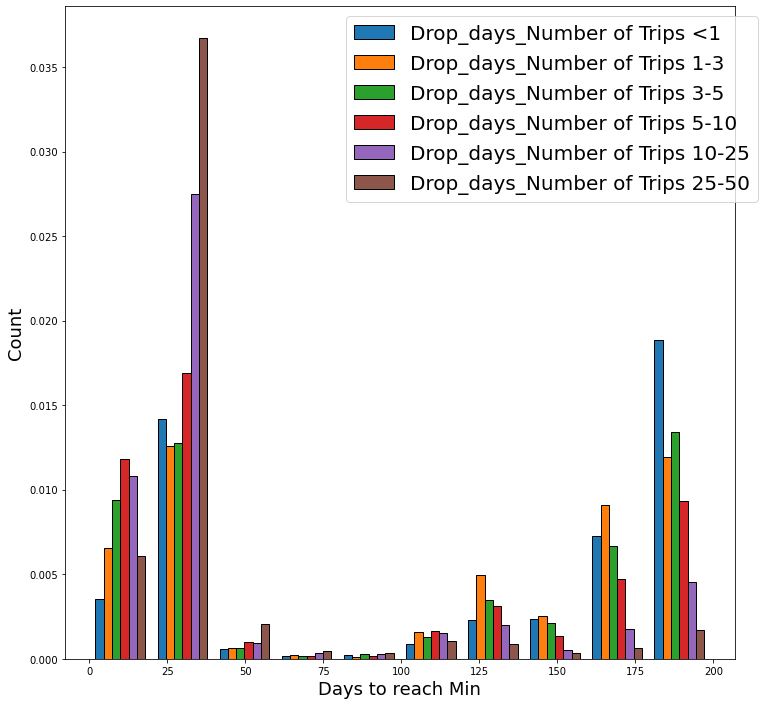

In [82]:
target_cols_red = [col for col in df_mob_red.columns if 'Drop_days_Number of Trips ' in col]
plot_metric(df_mob_red,target_cols_red,x_label='Days to reach Min')

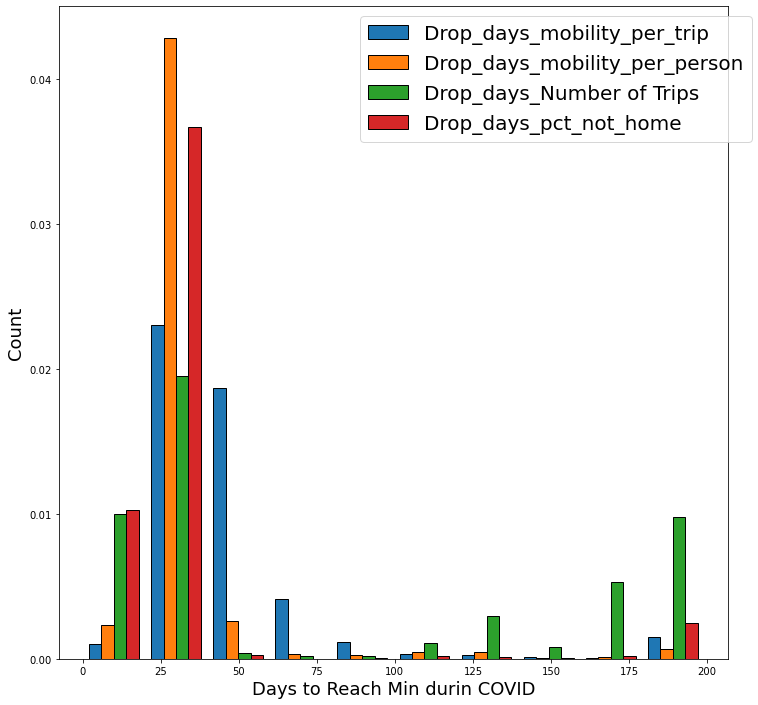

In [83]:
target_cols_drop_days = ['Drop_days_' + col for col in cols]
plot_metric(df_mob_red,target_cols_drop_days,x_label='Days to Reach Min durin COVID')

In [441]:
covid_date = datetime.datetime.strptime('2020-03-15', '%Y-%m-%d')
df_covid_case_mean = pd.DataFrame(columns=['fips','mean_case_rate' ])
df_covid_death_mean = pd.DataFrame(columns=['fips','mean_death_rate' ])
df_covid_tr = df_covid[df_covid.date >=covid_date]
for fips in df_mob_red.fips.unique():
    date_thr = df_mob_red[df_mob_red.fips==fips]['min_date_mobility_per_person'].values[0]
    cases_on_march_15 = df_covid_tr[(df_covid_tr.fips==fips)& (df_covid_tr.date==covid_date)]['Total_cases'].values[0]
    mean_case_rate = df_covid_tr[(df_covid_tr.fips==fips)& (df_covid_tr.date<=date_thr)]['Daily_cases'].mean()
    mean_death_rate = df_covid_tr[(df_covid_tr.fips==fips)& (df_covid_tr.date<=date_thr)]['Daily_deaths'].mean()
    cases_on_min_mob_date = df_covid_tr[(df_covid_tr.fips==fips)& (df_covid_tr.date==date_thr)]['Total_cases'].values[0]
    df_covid_case_mean = df_covid_case_mean.append({'fips':fips,'mean_case_rate':mean_case_rate,
                                                   'cases_on_march_15':cases_on_march_15,
                                                    'cases_on_min_mob_date':cases_on_min_mob_date},ignore_index=True)
    
    deaths_on_march_15 = df_covid_tr[(df_covid_tr.fips==fips)& (df_covid_tr.date==covid_date)]['Total_deaths'].values[0]
    deaths_on_min_mob_date = df_covid_tr[(df_covid_tr.fips==fips)& (df_covid_tr.date==date_thr)]['Total_deaths'].values[0]
    df_covid_death_mean = df_covid_death_mean.append({'fips':fips,'mean_death_rate':mean_death_rate,
                                                     'deaths_on_march_15':deaths_on_march_15,
                                                     'deaths_on_min_mob_date':deaths_on_min_mob_date},ignore_index=True)

df_covid_rate = df_covid_case_mean.join(df_covid_death_mean.set_index('fips'),on='fips')

In [442]:
sheet_list = ['State of Emergency','Physical Distance Closures','Stay at Home',
              'Unemployment Insurance','Housing','Quarantine Rules','Food Security']

In [443]:
def get_model_df(df_mob_red,df_covid_rate,df_county_demo,sheet_list,df_ur,df_hi,df_pop_est,df_quart_emp_wages):
    df_model = df_mob_red.join(df_covid_rate.set_index('fips'), on='fips')
    df_model = df_model.join(df_county_demo.set_index('fips'), on ='fips')
    df_model= df_model.dropna()
    
    df_CUSP = pd.DataFrame()
    for sheet in sheet_list:
        df_CUSP_sheet = collect_datasets.load_CUSP(sheet)
        if len(df_CUSP)!=0:
            df_CUSP = df_CUSP.join(df_CUSP_sheet.set_index('STATE'), on='STATE')
        else:
            df_CUSP = df_CUSP_sheet.copy()
            
    df_model = df_model.join(df_CUSP.set_index('STATE'), on='STATE')
    df_atlas = collect_datasets.load_Atlas()
    df_model = df_model.join(df_atlas.set_index('FIPS'),on='fips')
    df_model = df_model.join(df_ur.set_index('fips'),on='fips')
    df_model = df_model.join(df_hi.set_index('fips'),on='fips')
    df_model = df_model.join(df_pop_est.set_index('fips'),on='fips')
    df_model = df_model.join(df_quart_emp_wages.set_index('fips'),on='fips')
    df_model = df_model.fillna(df_model.median())
    return df_model.reset_index(drop=True)

In [ ]:
def get_model_df(df_mob_red,df_covid_rate,df_county_demo,sheet_list,df_ur):
    df_model = df_mob_red.join(df_covid_rate.set_index('fips'), on='fips')
    df_model = df_model.join(df_county_demo.set_index('fips'), on ='fips')
    df_CUSP = pd.DataFrame()
    for sheet in sheet_list:
        df_CUSP_sheet = collect_datasets.load_CUSP(sheet)
        if len(df_CUSP)!=0:
            df_CUSP = df_CUSP.join(df_CUSP_sheet.set_index('STATE'), on='STATE')
        else:
            df_CUSP = df_CUSP_sheet.copy()
            
    df_model = df_model.join(df_CUSP.set_index('STATE'), on='STATE')
    df_atlas = collect_datasets.load_Atlas()
    df_model = df_model.join(df_atlas.set_index('FIPS'),on='fips')
    df_model = df_model.join(df_ur.set_index('fips'),on='fips')

    return df_model

In [455]:
def run_model(df,df_source,name,target_var,task_type='GPU',max_depth= 6,plot=True,plot_shap=False):
    
    
    keep_cols = target_var + [('_').join(target_var[0].split('_')[2:])]
    remove_cols = ['fips', 'YEAR','COUNTY','NAME_E' ] + [col for col in df_source.columns if col not in keep_cols]
    df_final = df.drop(columns=remove_cols)
    df_final = df_final.dropna()
    X =df_final.drop(columns=target_var)
    y =df_final[target_var]
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
    cat_index = [X.columns.get_loc("STATE"),X.columns.get_loc("party")]
    
    cb_model = catboost.CatBoostRegressor(task_type=task_type, n_estimators=500, eval_metric='R2',
                                      max_depth=max_depth,devices='0',learning_rate=0.25,verbose=250,cat_features=cat_index)
    cb_model.fit(X_train,y_train)
    y_pred_cb = cb_model.predict(X_test)
    r2score = np.round(r2_score(y_test,y_pred_cb),2)
    print("R2 for ",target_var, ' Model is', r2score)
    test = y_test.values.flatten()
    if plot:
        plt.scatter(y_test,(test-y_pred_cb)*100/test,s=2)
        plt.yscale('symlog')
        plt.xscale('log')
        plt.xlabel('y_true')
        plt.ylabel('Error (%)')
        plt.ylim(-500,500)
        plt.show()
    if plot_shap:
        shap_values_ks = cb_model.get_feature_importance(
        Pool(X_test, label=y_test, cat_features=cat_index),
        type="ShapValues")
        shap_values_ks = shap_values_ks[:, :-1]

        shap.summary_plot(shap_values_ks, X_test)
    
    df_cb_feat_imp =  pd.DataFrame(cb_model.feature_importances_, X_train.columns,columns=[name +'_Covid_Feature_Importance'])
    return df_cb_feat_imp,y_test,y_pred_cb,r2score


In [445]:
df_model = get_model_df(df_mob_red,df_covid_rate,df_county,sheet_list,df_ur,df_hi,df_pop_est,df_quart_emp_wages)

merging between different levels can give an unintended result (1 levels on the left,3 on the right)
DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


In [454]:
df_model_fi,y_test,y_pred_cb,r2score = run_model(df_model,df_mob_red,name = 'Red_Mob',target_var=['Mob_Red_Index_scaled'], 
                                             task_type='CPU',max_depth = 6,plot=False)

R2 for  ['Mob_Red_Index_scaled']  Model is 0.27


In [90]:
pd.set_option('display.max_colwidth', None)
pct_red_cols = [col for col in df_mob_red.columns if 'Pct_' in col]
cols = ['target_var','R2_Score','Top 5 Features']
df_model_summary = pd.DataFrame(columns = cols)
for col in pct_red_cols:
    df_model_fi,y_test,y_pred_cb,r2score = run_model(df_model,df_mob_red,name = 'Red_Mob',target_var=[col], 
                                             task_type='CPU',max_depth = 7,plot=False)
    top_features = list(df_model_fi.sort_values('Red_Mob_Covid_Feature_Importance',ascending=False)[:5].index)
    df_model_ = pd.DataFrame([[col,r2score,top_features]],columns=cols)

    df_model_summary = df_model_summary.append(df_model_,ignore_index=True,)
df_model_summary  

R2 for  ['Pct_Red_mobility_per_trip']  Model is 0.38
R2 for  ['Pct_Red_mobility_per_person']  Model is 0.34
R2 for  ['Pct_Red_trips_per_person']  Model is 0.49
R2 for  ['Pct_Red_Number of Trips']  Model is 0.47
R2 for  ['Pct_Red_pct_not_home']  Model is 0.77
R2 for  ['Pct_Red_Number of Trips <1']  Model is 0.52
R2 for  ['Pct_Red_Number of Trips 1-3']  Model is 0.51
R2 for  ['Pct_Red_Number of Trips 3-5']  Model is 0.53
R2 for  ['Pct_Red_Number of Trips 5-10']  Model is 0.48
R2 for  ['Pct_Red_Number of Trips 10-25']  Model is 0.36
R2 for  ['Pct_Red_Number of Trips 25-50']  Model is 0.32


target_var  R2_Score  \
0       Pct_Red_mobility_per_trip      0.38   
1     Pct_Red_mobility_per_person      0.34   
2        Pct_Red_trips_per_person      0.49   
3         Pct_Red_Number of Trips      0.47   
4            Pct_Red_pct_not_home      0.77   
5      Pct_Red_Number of Trips <1      0.52   
6     Pct_Red_Number of Trips 1-3      0.51   
7     Pct_Red_Number of Trips 3-5      0.53   
8    Pct_Red_Number of Trips 5-10      0.48   
9   Pct_Red_Number of Trips 10-25      0.36   
10  Pct_Red_Number of Trips 25-50      0.32   

                                                                                                                                                           Top 5 Features  
0                                                                                      [PctEmpTrans, Sex by Age_Male 30 to 34 years, STATE, NumEmployed2014, Births_2014]  
1     [STATE, Days_SNAP Waiver-Emergency Allotments to Current SNAP Households, (February Employment, Private, 1021), Ed1LessThanHSNum, Sex by Age_Female 25 to 29 years]  
2        [Days_SNAP Waiver-Emergency Allotments to Current SNAP Households, STATE, Means of Transportation to Work_Car, truck, or van, pct_republican, tax_st_diff_top20]  
3   [Days_SNAP Waiver-Emergency Allotments to Current SNAP Households, STATE, Means of Transportation to Work_Car, truck, or van, tax_st_diff_top20, reimb_penroll_adj10]  
4                                                                                    [pct_not_home, median_house_value, Under18Num2010, hhinc00, BlackNonHispanicPct2010]  
5                                                                      [STATE, reimb_penroll_adj10, PopDensity2010, pop_density, Days_Closed restaurants except take out]  
6                                                                                  [STATE, Ed2HSDiplomaOnlyNum, PopDensity2010, MultipleRacePct2010, reimb_penroll_adj10]  
7         [STATE, Means of Transportation to Work_Car, truck, or van, Days_SNAP Waiver-Emergency Allotments to Current SNAP Households, Deaths_2015, LandAreaSQMiles2010]  
8                                                                             [pop_density, STATE, Ed2HSDiplomaOnlyNum, PopDensity2010, NativeAmericanNonHispanicPct2010]  
9          [Means of Transportation to Work_Car, truck, or van, Under18Num2010, NativeAmericanNonHispanicPct2010, Days_Stay at home/ shelter in place, POP_ESTIMATE_2010]  
10                       [Travel Time to Work_45 to 59 minutes, PctEmpTrans, (Total Quarterly Wages, Private, 102), Under18Num2010, Travel Time to Work_20 to 24 minutes]

In [55]:
drop_days_cols = [col for col in df_mob_red.columns if 'Drop_days' in col]
cols = ['target_var','R2_Score','Top 5 Features']
df_model_summary_days = pd.DataFrame(columns = cols)
for col in drop_days_cols:
    df_model_fi,y_test,y_pred_cb,r2score = run_model(df_model,df_mob_red,name = 'Red_Mob',target_var=[col], 
                                             task_type='CPU',max_depth = 7,plot=False)
    top_features = list(df_model_fi.sort_values('Red_Mob_Covid_Feature_Importance',ascending=False)[:5].index)
    df_model_ = pd.DataFrame([[col,r2score,top_features]],columns=cols)

    df_model_summary_days = df_model_summary_days.append(df_model_,ignore_index=True,)
df_model_summary_days

R2 for  ['Drop_days_mobility_per_trip']  Model is 0.05
R2 for  ['Drop_days_mobility_per_person']  Model is 0.52
R2 for  ['Drop_days_trips_per_person']  Model is 0.23
R2 for  ['Drop_days_Number of Trips']  Model is 0.22
R2 for  ['Drop_days_pct_not_home']  Model is 0.03
R2 for  ['Drop_days_Number of Trips <1']  Model is 0.2
R2 for  ['Drop_days_Number of Trips 1-3']  Model is 0.18
R2 for  ['Drop_days_Number of Trips 3-5']  Model is 0.28
R2 for  ['Drop_days_Number of Trips 5-10']  Model is 0.19
R2 for  ['Drop_days_Number of Trips 10-25']  Model is 0.15
R2 for  ['Drop_days_Number of Trips 25-50']  Model is 0.18


target_var  R2_Score  \
0       Drop_days_mobility_per_trip      0.05   
1     Drop_days_mobility_per_person      0.52   
2        Drop_days_trips_per_person      0.23   
3         Drop_days_Number of Trips      0.22   
4            Drop_days_pct_not_home      0.03   
5      Drop_days_Number of Trips <1      0.20   
6     Drop_days_Number of Trips 1-3      0.18   
7     Drop_days_Number of Trips 3-5      0.28   
8    Drop_days_Number of Trips 5-10      0.19   
9   Drop_days_Number of Trips 10-25      0.15   
10  Drop_days_Number of Trips 25-50      0.18   

                                                                                                                                                                                       Top 5 Features  
0                                                                                    [NumCivLaborForce2009, POP_ESTIMATE_2017, NumCivLaborforce2007, NonEnglishHHPct, Sex by Age_Male 15 to 17 years]  
1                                                                                                            [cases_on_min_mob_date, NumEmployed2009, NumCivLaborForce2010, Deaths_2015, Births_2012]  
2                                                                                                    [cs_frac_black, trips_per_person, Ed1LessThanHSPct, STATE, Race_Black or African American alone]  
3                                                                                                    [cs_frac_black, Ed1LessThanHSPct, STATE, Race_Black or African American alone, Race_White alone]  
4                                                                                           [cs_fam_wkidsinglemom, Race_White alone, Sex by Age_Male 21 years, bmi_obese_q1, WhiteNonHispanicPct2010]  
5                                                                           [e_rank_b, Travel Time to Work_Less than 5 minutes, STATE, Race_Black or African American alone, BlackNonHispanicPct2010]  
6                                                                                          [cs_frac_black, scap_ski90pcm, frac_traveltime_lt15, score_r, Means of Transportation to Work_Other means]  
7                            [Race_Black or African American alone, (Total Wage Location Quotient Relative to U.S., Private, 1026), cs_frac_black, cs00_seg_inc_pov25, Days_SNAP Waiver-Pandemic EBT]  
8                                                            [Race_Black or African American alone, WhiteNonHispanicPct2010, Travel Time to Work_5 to 9 minutes, WhiteNonHispVetsPct, PopDensity2010]  
9   [Travel Time to Work_25 to 29 minutes, Travel Time to Work_35 to 39 minutes, Sex by Age_Male 45 to 49 years, (Employment Location Quotient Relative to U.S., Private, 1011), R_DOMESTIC_MIG_2017]  
10                                                [Travel Time to Work_45 to 59 minutes, PopDensity2010, Travel Time to Work_30 to 34 minutes, Labor_Force|Dec-19, NonHispanicAsianPopChangeRate0010]

In [68]:
norm_drop_rate = [col for col in df_mob_red.columns if 'Norm_' in col]
cols = ['target_var','R2_Score','Top 5 Features']
df_model_summary_days = pd.DataFrame(columns = cols)
for col in norm_drop_rate:
    df_model_fi,y_test,y_pred_cb,r2score = run_model(df_model,df_mob_red,name = 'Red_Mob',target_var=[col], 
                                             task_type='CPU',max_depth = 7,plot=False)
    top_features = list(df_model_fi.sort_values('Red_Mob_Covid_Feature_Importance',ascending=False)[:5].index)
    df_model_ = pd.DataFrame([[col,r2score,top_features]],columns=cols)

    df_model_summary_days = df_model_summary_days.append(df_model_,ignore_index=True,)
df_model_summary_days

R2 for  ['Norm_Drop_Rate_mobility_per_trip']  Model is 0.13
R2 for  ['Norm_Drop_Rate_mobility_per_person']  Model is 0.27
R2 for  ['Norm_Drop_Rate_trips_per_person']  Model is 0.23
R2 for  ['Norm_Drop_Rate_Number of Trips']  Model is 0.23
R2 for  ['Norm_Drop_Rate_pct_not_home']  Model is 0.15
R2 for  ['Norm_Drop_Rate_Number of Trips <1']  Model is 0.0
R2 for  ['Norm_Drop_Rate_Number of Trips 1-3']  Model is -0.13
R2 for  ['Norm_Drop_Rate_Number of Trips 3-5']  Model is 0.03
R2 for  ['Norm_Drop_Rate_Number of Trips 5-10']  Model is 0.01
R2 for  ['Norm_Drop_Rate_Number of Trips 10-25']  Model is 0.11
R2 for  ['Norm_Drop_Rate_Number of Trips 25-50']  Model is 0.05


target_var  R2_Score                                                                                                                                                                        Top 5 Features
0       Norm_Drop_Rate_mobility_per_trip      0.13                                                                [VietnamEraVetsPct, Unemployed_Pct|Aug-19, PctEmpTrans, Means of Transportation to Work_Motorcycle, PopChangeRate0010]
1     Norm_Drop_Rate_mobility_per_person      0.27                                           [cases_on_min_mob_date, mean_case_rate, Travel Time to Work_Total, PctEmpTrans, Race_Two or more races Two races including Some other race]
2        Norm_Drop_Rate_trips_per_person      0.23                                                         [STATE, BlackNonHispanicPct2010, Ed1LessThanHSPct, Days_Stay at home/ shelter in place, Race_Black or African American alone]
3         Norm_Drop_Rate_Number of Trips      0.23                                                         [STATE, BlackNonHispanicPct2010, Ed1LessThanHSPct, Days_Stay at home/ shelter in place, Race_Black or African American alone]
4            Norm_Drop_Rate_pct_not_home      0.15                                                                 [PctEmpConstruction, PctEmpAgriculture, Means of Transportation to Work_Car, truck, or van, STATE, PopChangeRate1019]
5      Norm_Drop_Rate_Number of Trips <1      0.00                                                               [Deep_Pov_Children, Travel Time to Work_5 to 9 minutes, PctEmpInformation, Sex by Age_Male 21 years, PovertyUnder18Num]
6     Norm_Drop_Rate_Number of Trips 1-3     -0.13                                             [UnempRate2015, Unemployed_Pct|Jul-19, cases_on_march_15, NativeAmericanNonHispanicPct2010, Race_American Indian and Alaska Native alone]
7     Norm_Drop_Rate_Number of Trips 3-5      0.03       [Ed1LessThanHSPct, Unemployed_Pct|Apr-20, PctEmpConstruction, Unemployed_Pct|Feb-20, Gross Rent as a Percentage of Household Income in the Past 12 Months_20.0 to 24.9 percent]
8    Norm_Drop_Rate_Number of Trips 5-10      0.01                     [PctNonVetsDisabilty, Days_Stay at home/ shelter in place, Days_Closed non-essential businesses, PctEmpManufacturing, Days_Waived one week waiting period for UI]
9   Norm_Drop_Rate_Number of Trips 10-25      0.11                             [UnempRate2015, Unemployed_Pct|Oct-19, Days_Stay at home/ shelter in place, Means of Transportation to Work_Car, truck, or van, Sex by Age_Male 20 years]
10  Norm_Drop_Rate_Number of Trips 25-50      0.05  [Race_Native Hawaiian and Other Pacific Islander alone, Unemployed_Pct|Oct-19, Means of Transportation to Work_Walked, Days_Stay at home/ shelter in place, BlackNonHispanicNum2010]

0:	learn: 0.1392556	total: 87.5ms	remaining: 43.7s
200:	learn: 0.9898493	total: 15.2s	remaining: 22.6s
400:	learn: 0.9993366	total: 30.5s	remaining: 7.54s
499:	learn: 0.9998272	total: 37.9s	remaining: 0us
R2 for  ['Pct_Red_pct_not_home']  Model is 0.81


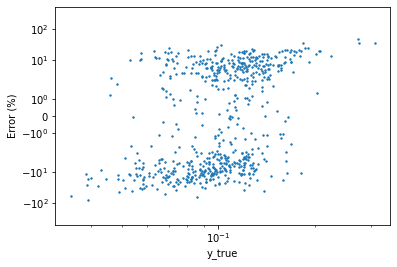

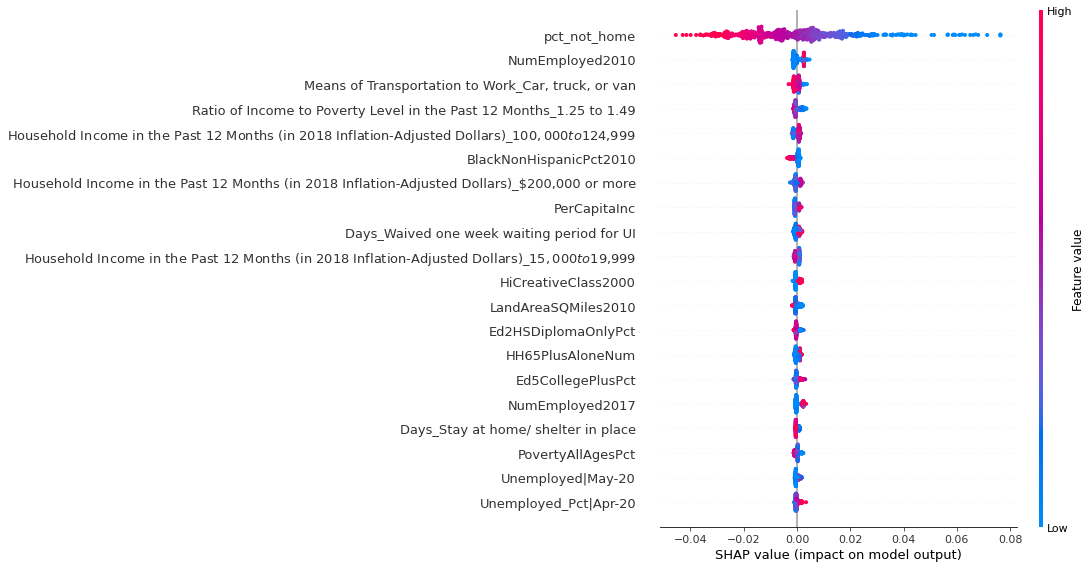

Red_Mob_Covid_Feature_Importance
pct_not_home                                                               38.753261
NumEmployed2010                                                             2.111077
Household Income in the Past 12 Months (in 2018...                          1.079924
BlackNonHispanicPct2010                                                     1.002794
Ed5CollegePlusPct                                                           0.921503
Ratio of Income to Poverty Level in the Past 12...                          0.903943
Travel Time to Work_60 to 89 minutes                                        0.848062
Household Income in the Past 12 Months (in 2018...                          0.846619
Means of Transportation to Work_Car, truck, or van                          0.817145
Household Income in the Past 12 Months (in 2018...                          0.796226
Employed|Jan-20                                                             0.784176
HiCreativeClass2000                                                         0.764116
Unemployed_Pct|May-20                                                       0.672331
Days_Waived one week waiting period for UI                                  0.599202
Household Income in the Past 12 Months (in 2018...                          0.569069
Travel Time to Work_5 to 9 minutes                                          0.558848
Unemployed_Pct|Apr-20                                                       0.545768
Days_Closed movie theaters                                                  0.539038
Race_Total                                                                  0.534437
Days_SNAP Waiver-Pandemic EBT                                               0.522824

In [253]:
df_model_fi,y_test,y_pred_cb = run_model(df_model,df_mob_red,name = 'Red_Mob',
                                         target_var=['Pct_Red_pct_not_home'], 
                                         task_type='CPU',max_depth = 7,plot_shap=True)
df_model_fi.sort_values('Red_Mob_Covid_Feature_Importance',ascending=False)[:20]